# Chapter 4. Generalizing Linear Models

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import jax.numpy as jnp
from jax import random, vmap, local_device_count, pmap
from jax import nn as jnn

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation


seed=1234

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system
numpyro.set_host_device_count(local_device_count())

In [2]:
# import pymc3 as pm
# import numpy as np
# import pandas as pd
# import theano.tensor as tt
# import seaborn as sns
# import scipy.stats as stats
# from scipy.special import expit as logistic
# import matplotlib.pyplot as plt
# import arviz as az

In [3]:
# az.style.use('arviz-darkgrid')

## Logistic regression

Text(0, 0.5, 'logistic(z)')

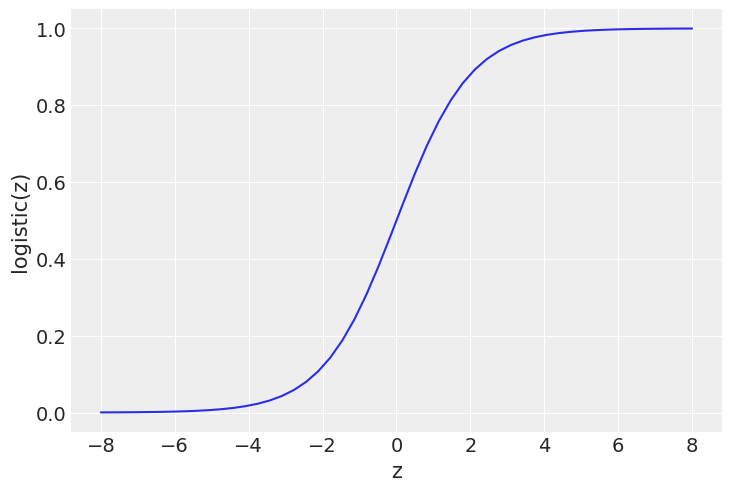

In [4]:
z = jnp.linspace(-8, 8)
plt.plot(z, 1 / (1 + jnp.exp(-z)))
plt.xlabel('z')
plt.ylabel('logistic(z)')

## The iris dataset

In [5]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


<AxesSubplot:xlabel='species', ylabel='sepal_length'>

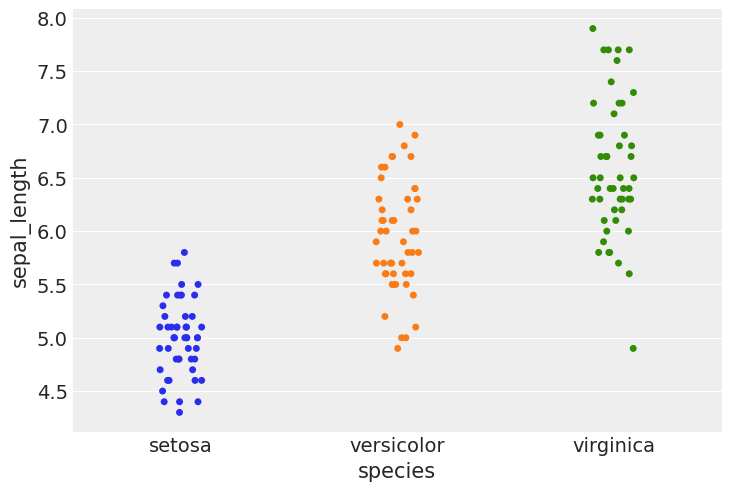

In [6]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)

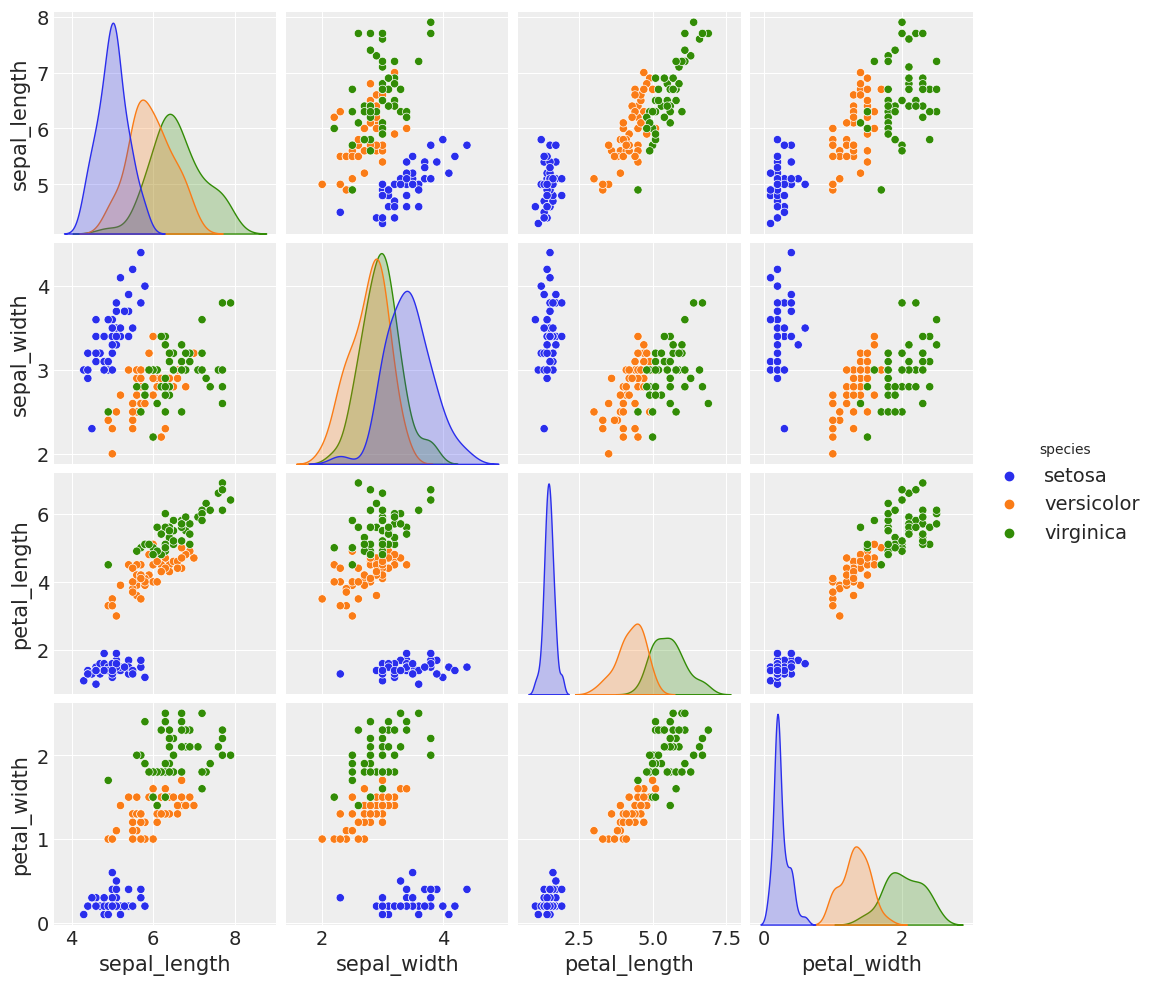

In [7]:
sns.pairplot(iris, hue='species', diag_kind='kde')

### The logistic model applied to the iris dataset

In [8]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [9]:
def model(obs=None):
    α = numpyro.sample('α', dist.Normal(loc=0, scale=10))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=1))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
    
    μ = α + jnp.dot(x_c, β)
    θ = numpyro.deterministic('θ', jnn.sigmoid(μ))
    bd = numpyro.deterministic('bd', -α/β)
    
    yl = numpyro.sample('yl', dist.Bernoulli(probs=θ), obs=obs)
    
    
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=4, chain_method='sequential')
mcmc.run(random.PRNGKey(seed), obs=y_0)

sample: 100%|████████████████████████| 10000/10000 [00:01<00:00, 5977.72it/s, 3 steps of size 6.80e-01. acc. prob=0.91]


In [10]:
varnames = ['α', 'β', 'bd']
az.summary(mcmc, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.134,0.273,-0.395,0.631,0.002,0.002,16846.0,14060.0,1.0
β,3.255,0.542,2.237,4.254,0.004,0.003,16426.0,13782.0,1.0
bd,-0.040,0.085,-0.204,0.116,0.001,0.001,17877.0,14539.0,1.0


In [11]:
# az.plot_trace(mcmc, compact=False)

In [12]:
jnp.squeeze(dist.Normal(y_0, 0.02).sample(random.PRNGKey(0), (1,)), axis=0).shape, x_c.shape

((100,), (100,))

([<matplotlib.axis.XTick at 0x131fc7f40>,
 [Text(-1.5, 0, '4.0'),
  Text(-1.0, 0, '4.5'),
  Text(-0.5, 0, '5.0'),
  Text(0.0, 0, '5.5'),
  Text(0.5, 0, '6.0'),
  Text(1.0, 0, '6.5'),
  Text(1.5, 0, '7.0'),
  Text(2.0, 0, '7.5')])

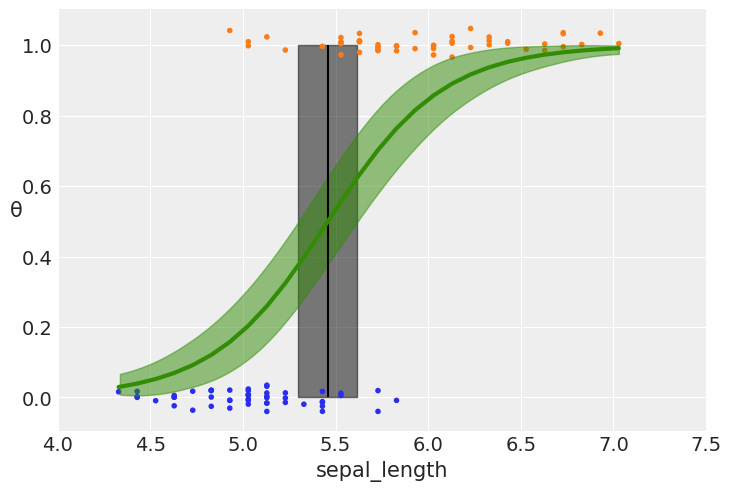

In [13]:
theta = mcmc.get_samples()['θ'].mean(axis=0)
idx = jnp.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)

plt.vlines(mcmc.get_samples()['bd'].mean(), 0, 1, color='k')

bd_hdi = az.hdi(mcmc.get_samples()['bd'].copy())
plt.fill_betweenx([0, 1], bd_hdi[0], bd_hdi[1], color='k', alpha=0.5)

plt.scatter(x_c, jnp.squeeze(dist.Normal(y_0, 0.02).sample(random.PRNGKey(0), (1,)), axis=0),
            marker='.', color=[f'C{x}' for x in y_0])
az.plot_hdi(x_c, mcmc.get_samples()['θ'], color='C2')

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, jnp.round(locs + x_0.mean(), 1))

# Multiple logistic regression

In [14]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_1 = df[x_n].values

In [15]:
def model(obs=None):
    α = numpyro.sample('α', dist.Normal(loc=0, scale=10))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=2), sample_shape=(len(x_n),))
    
    μ = α + jnp.dot(x_1, β)
    θ = numpyro.deterministic('θ', 1 / (1 + jnp.exp(-μ)))
    bd = numpyro.deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])
    
    yl = numpyro.sample('yl', dist.Bernoulli(probs=θ), obs=obs)
    
    
kernel = NUTS(model)
mcmc2 = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=2, chain_method='sequential')
mcmc2.run(random.PRNGKey(seed), obs=y_1)   

sample: 100%|███████████████████████| 10000/10000 [00:01<00:00, 5115.02it/s, 63 steps of size 5.24e-02. acc. prob=0.95]


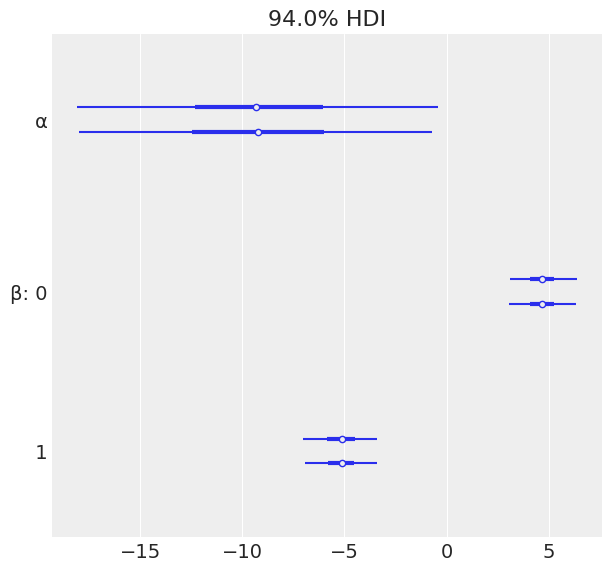

In [16]:
varnames = ['α', 'β'] 
az.plot_forest(mcmc2, var_names=varnames);

Text(0, 0.5, 'sepal_width')

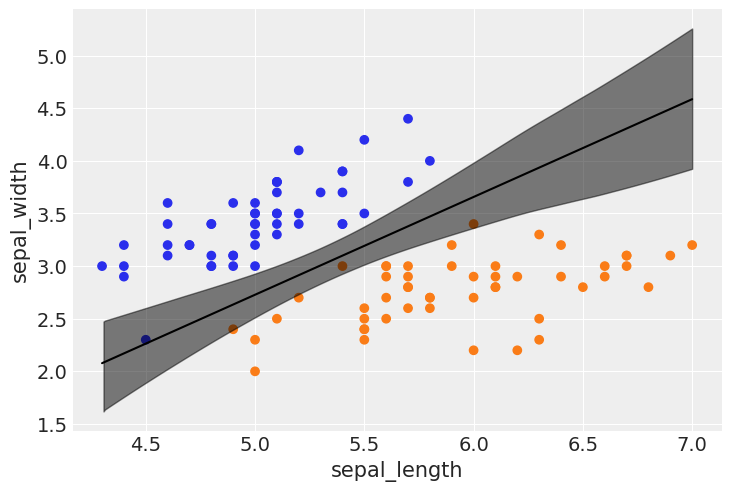

In [17]:
idx = jnp.argsort(x_1[:,0]) 
bd = mcmc2.get_samples()['bd'].mean(0)[idx] 
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_1[:,0][idx], bd, color='k'); 

az.plot_hdi(x_1[:,0], mcmc2.get_samples()['bd'], color='k')
 
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])

## Interpreting the coefficients of a logistic regression

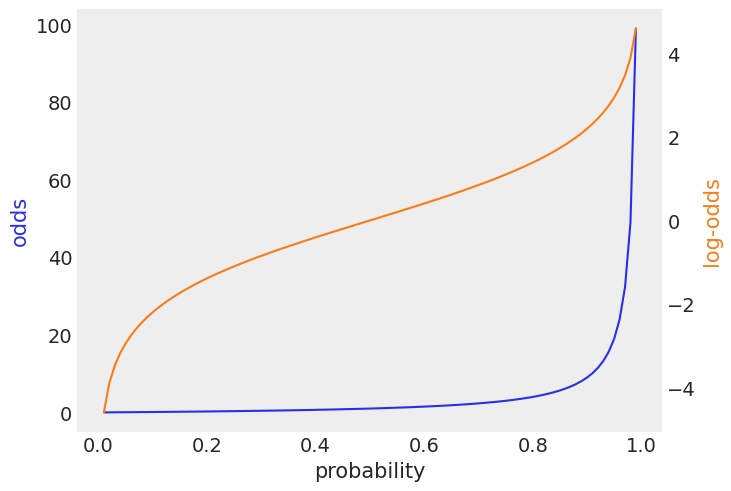

In [18]:
probability = jnp.linspace(0.01, 1, 100)
odds = probability / (1 - probability)

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(probability, odds, 'C0')
ax2.plot(probability, jnp.log(odds), 'C1')

ax1.set_xlabel('probability')
ax1.set_ylabel('odds', color='C0')
ax2.set_ylabel('log-odds', color='C1')
ax1.grid(False)
ax2.grid(False)

In [19]:
df = az.summary(mcmc2, var_names=varnames)
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-9.294,4.668,-18.053,-0.598,0.087,0.062,2878.0,3643.0,1.0
β[0],4.696,0.882,3.088,6.368,0.017,0.012,2651.0,3243.0,1.0
β[1],-5.185,0.981,-7.025,-3.437,0.016,0.012,3727.0,4204.0,1.0


In [20]:
from jax.scipy.special import expit as logistic

x_1 = 4.5  # sepal_length
x_2 = 3   # sepal_width 

log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic(log_odds_versicolor_i)


log_odds_versicolor_f = (df['mean'] * [1, x_1 + 1, x_2]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

log_odds_versicolor_f - log_odds_versicolor_i, probability_versicolor_f - probability_versicolor_i

(4.6960000000000015, DeviceArray(0.7031797, dtype=float32))

## Dealing with correlated variables

In [21]:
corr = iris[iris['species'] != 'virginica'].corr() 

In [22]:
mask = jnp.tri(*corr.shape).T 

In [23]:
type(mask.copy())

numpy.ndarray

In [24]:
jnp.abs(jnp.asarray(corr))

DeviceArray([[1.        , 0.20592576, 0.81245786, 0.78960824],
             [0.20592576, 1.        , 0.6026631 , 0.5708832 ],
             [0.81245786, 0.6026631 , 1.        , 0.9793217 ],
             [0.78960824, 0.5708832 , 0.9793217 , 1.        ]],            dtype=float32)

<AxesSubplot:>

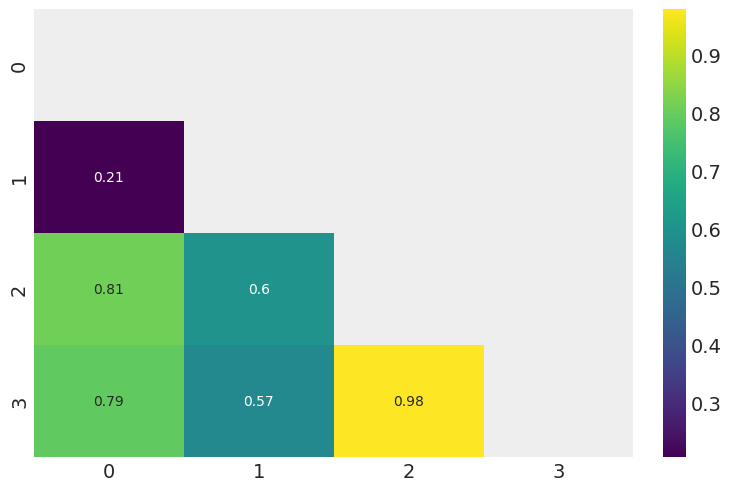

In [25]:
sns.heatmap(jnp.abs(jnp.asarray(corr)), mask=mask.copy(), annot=True, cmap='viridis')

## Dealing with unbalanced classes

In [26]:
df = iris.query("species == ('setosa', 'versicolor')") 
df = df[45:]  
y_3 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values

In [27]:
def model(obs=None):
    α = numpyro.sample('α', dist.Normal(loc=0, scale=10))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=2), sample_shape=(len(x_n),))
    
    μ = α + jnp.dot(x_3, β)
    θ = numpyro.deterministic('θ', 1 / (1 + jnp.exp(-μ)))
    bd = numpyro.deterministic('bd', -α/β[1] - β[0]/β[1] * x_3[:,0])
    
    yl = numpyro.sample('yl', dist.Bernoulli(probs=θ), obs=obs)
    
    
kernel = NUTS(model)
mcmc3 = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=2, chain_method='sequential')
mcmc3.run(random.PRNGKey(seed), obs=y_3) 

sample: 100%|█████████████████████████| 1500/1500 [00:00<00:00, 4949.02it/s, 63 steps of size 6.91e-02. acc. prob=0.95]


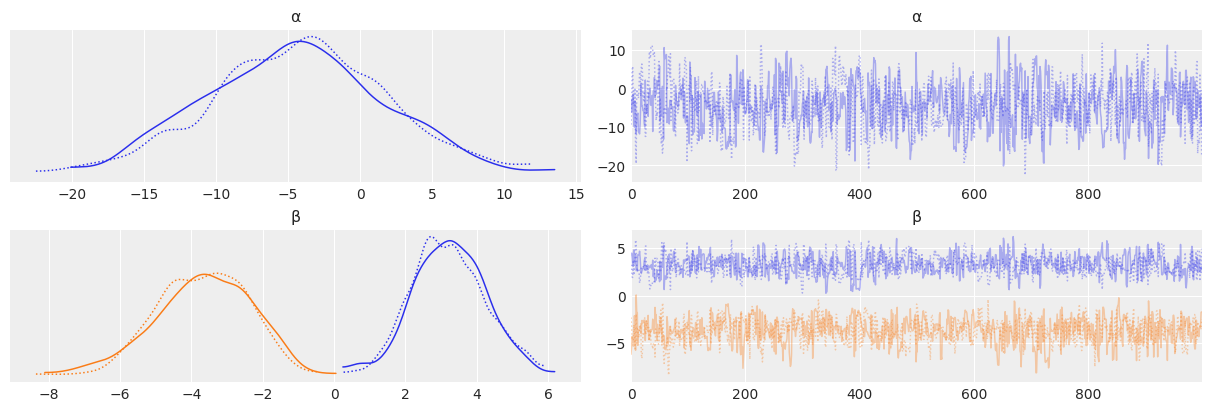

In [28]:
az.plot_trace(mcmc3, varnames);

Text(0, 0.5, 'sepal_width')

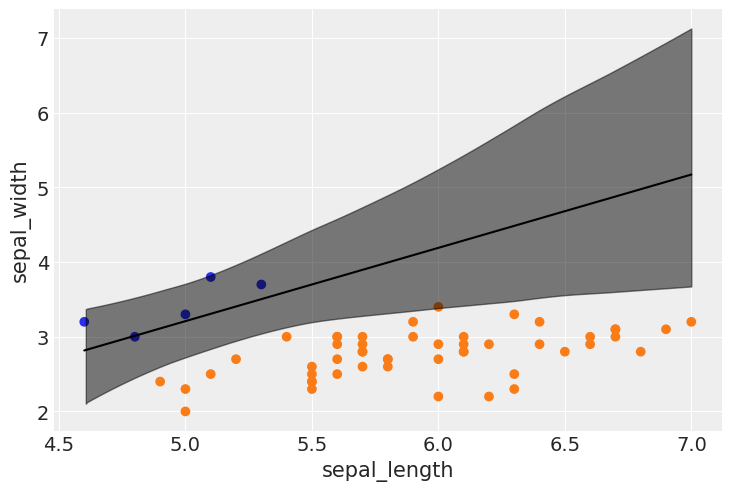

In [29]:
idx = jnp.argsort(x_3[:,0]) 
bd = mcmc3.get_samples()['bd'].mean(0)[idx] 
plt.scatter(x_3[:,0], x_3[:,1], c= [f'C{x}' for x in y_3]) 
plt.plot(x_3[:,0][idx], bd, color='k')

az.plot_hdi(x_3[:,0], mcmc3.get_samples()['bd'], color='k')

plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])

## Softmax regression

In [30]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

In [31]:
def model(obs=None):
    α = numpyro.sample('α', dist.Normal(loc=0, scale=5), sample_shape=(3,))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=5), sample_shape=(4,3))
    
    μ = numpyro.deterministic('μ', α + jnp.dot(x_s, β))
    θ = jnn.softmax(μ)
    
    yl = numpyro.sample('yl', dist.Categorical(probs=θ), obs=obs)
    
    
kernel = NUTS(model)
mcmc4 = MCMC(kernel, num_warmup=500, num_samples=1500, num_chains=2, chain_method='sequential')
mcmc4.run(random.PRNGKey(seed), obs=y_s) 

sample: 100%|█████████████████████████| 2000/2000 [00:01<00:00, 1888.53it/s, 63 steps of size 6.81e-02. acc. prob=0.94]


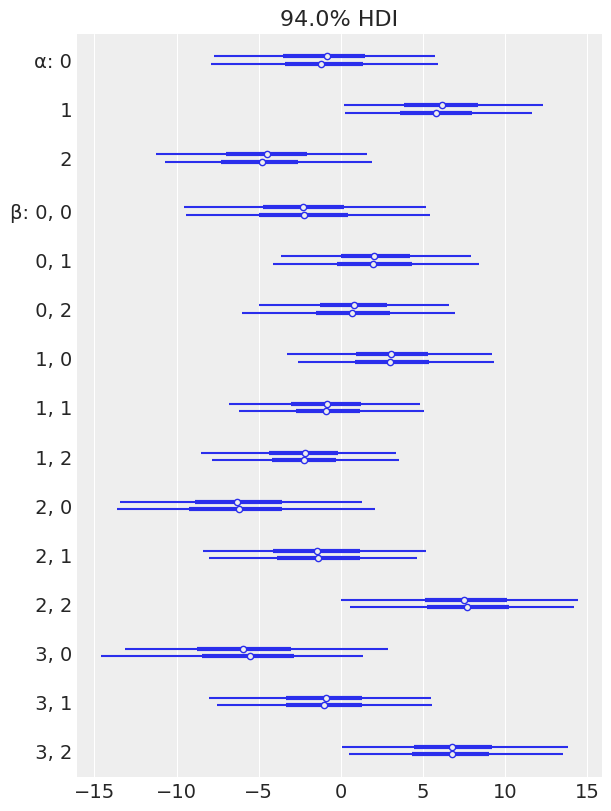

In [32]:
az.plot_forest(mcmc4, var_names=['α', 'β']);

In [33]:
data_pred = mcmc4.get_samples()['μ'].mean(0)

y_pred = jnp.asarray([jnp.exp(point) / jnp.sum(jnp.exp(point), axis=0) for point in data_pred])

f'{jnp.sum(y_s == jnp.argmax(y_pred, axis=1)) / len(y_s):.2f}'

'0.98'

In [34]:
def model(obs=None):
    α = numpyro.sample('α', dist.Normal(loc=0, scale=2), sample_shape=(2,))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=2), sample_shape=(4,2))
    
    α_f = jnp.concatenate(jnp.array([jnp.zeros((2)), α]))
    β_f = jnp.concatenate(jnp.array([jnp.zeros((4,2)), β]), axis=1)
    
    μ = α_f + jnp.dot(x_s, β_f)
    θ = jnn.softmax(μ)
    yl = numpyro.sample('yl', dist.Categorical(probs=θ), obs=obs)
    
    
kernel = NUTS(model)
mcmc5 = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=2, chain_method='sequential')
mcmc5.run(random.PRNGKey(seed), obs=y_s) 

sample: 100%|█████████████████████████| 1000/1000 [00:00<00:00, 2847.35it/s, 15 steps of size 2.26e-01. acc. prob=0.94]


## Discriminative and generative models

In [35]:
def model(obs=None):
    μ = numpyro.sample('μ', dist.Normal(loc=0, scale=10), sample_shape=(2,))
    σ = numpyro.sample('σ', dist.HalfNormal(scale=10))
    
    setosa = numpyro.sample('setosa', dist.Normal(loc=μ[0], scale=σ), obs=obs)
    versicolor = numpyro.sample('versicolor', dist.Normal(loc=μ[1], scale=σ), obs=obs)
    bd = numpyro.deterministic('bd', (μ[0] + μ[1]) / 2)
    
    
kernel = NUTS(model)
mcmc6 = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=2, chain_method='sequential')
mcmc6.run(random.PRNGKey(seed), obs=x_0[:50]) 

sample: 100%|██████████████████████████| 1000/1000 [00:00<00:00, 5580.45it/s, 7 steps of size 7.80e-01. acc. prob=0.92]


In [36]:
# dist.Normal(y_0, 0.02).sample(random.PRNGKey(1), (len(x_0),)).copy()

Text(0.5, 0, 'sepal_length')

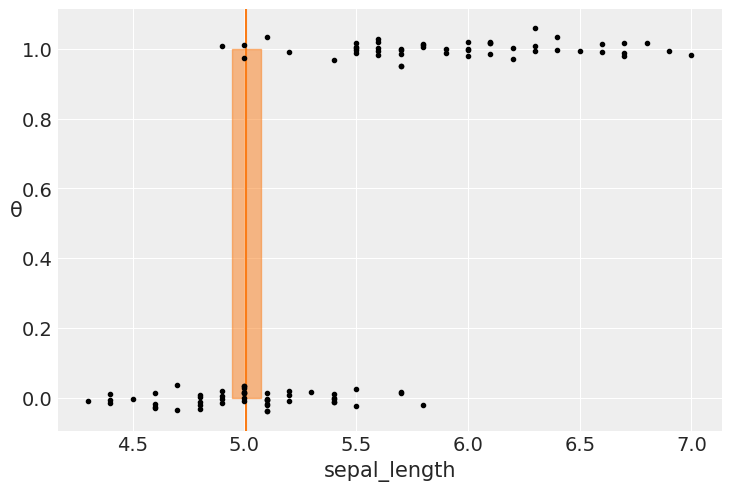

In [37]:
plt.axvline(mcmc6.get_samples()['bd'].mean(), ymax=1, color='C1')
bd_hdi = az.hdi(mcmc6.get_samples()['bd'].copy())

plt.fill_betweenx([0, 1], bd_hdi[0], bd_hdi[1], color='C1', alpha=0.5)
plt.plot(x_0, dist.Normal(y_0, 0.02).sample(random.PRNGKey(1)),'.', color='k') # np.random.normal(y_0, 0.02)
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')

In [38]:
az.summary(mcmc6)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bd,5.006,0.035,4.945,5.074,0.001,0.001,1024.0,810.0,1.0
μ[0],5.005,0.052,4.916,5.114,0.002,0.001,919.0,543.0,1.0
μ[1],5.008,0.050,4.914,5.104,0.002,0.001,960.0,814.0,1.0
σ,0.357,0.026,0.317,0.409,0.001,0.001,725.0,753.0,1.0


### The Poisson distribution

Text(0, 0.5, 'f(x)')

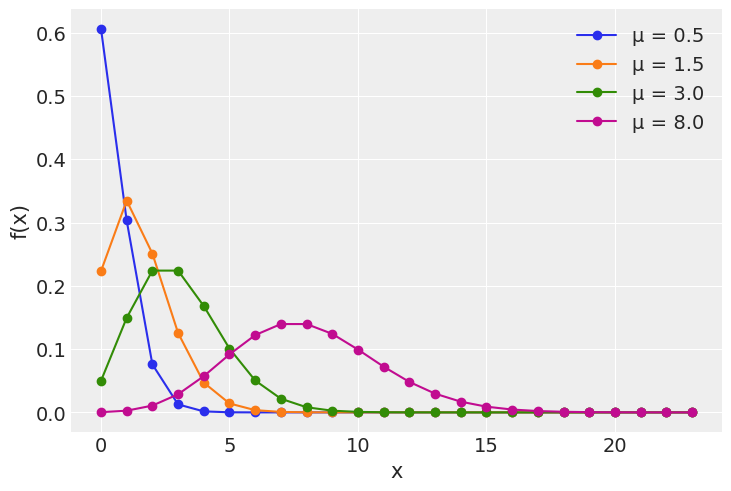

In [39]:
mu_params = [0.5, 1.5, 3, 8]
x = jnp.arange(0, max(mu_params) * 3)
for mu in mu_params:
    y = jnp.exp(dist.Poisson(rate=mu).log_prob(x)) # PMF - discrete, PDF - continous
#     y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

## The Zero-Inflated Poisson model

In [40]:
n = 100
θ_real = 2.5
ψ = 0.1

# Simulate some data
import numpy as onp
counts = onp.array([(onp.random.random() > (1-ψ)) * 
                   onp.random.poisson(θ_real) for i in range(n)])

counts

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5])

In [41]:
random.split(key=random.PRNGKey(1), num=1)

DeviceArray([[1948878966, 4237131848]], dtype=uint32)

In [42]:
print(dist.Uniform().sample(key=random.PRNGKey(1)) > (1-ψ))
print(dist.Uniform().sample(key=random.PRNGKey(1)))

False
0.118150234


In [43]:
print(random.uniform(key=random.PRNGKey(n)) > (1-ψ))
print(dist.Uniform().sample(key=random.PRNGKey(1)))

False
0.118150234


In [44]:
n = 100
θ_real = 2.5
ψ = 0.1

# Simulate some data
counts = jnp.array([(random.uniform(key=random.PRNGKey(i)) > (1-ψ)) *  dist.Poisson(θ_real).sample(key=random.PRNGKey(i)) for i in range(n)])
counts

DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
             0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 5, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
             0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],            dtype=int32)

In [45]:
def model(obs=None):
    ψ = numpyro.sample('ψ', dist.Beta(concentration1=1, concentration0=1))
    θ = numpyro.sample('θ', dist.Gamma(concentration=2, rate=0.1))
    
    y = numpyro.sample('y', dist.ZeroInflatedPoisson(gate=ψ, rate=θ), obs=obs)
                       
kernel = NUTS(model)
mcmc7 = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=2, chain_method='sequential')
mcmc7.run(random.PRNGKey(seed), obs=counts) 

sample: 100%|██████████████████████████| 1000/1000 [00:00<00:00, 5275.99it/s, 7 steps of size 9.06e-01. acc. prob=0.91]


array([[<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>],
       [<AxesSubplot:title={'center':'ψ'}>,
        <AxesSubplot:title={'center':'ψ'}>]], dtype=object)

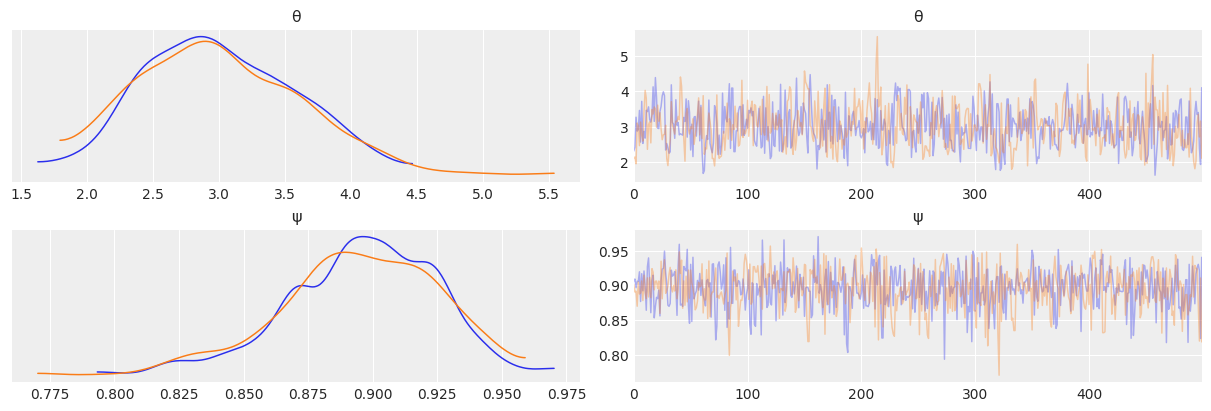

In [46]:
az.plot_trace(mcmc7, compact=False)

In [47]:
az.summary(mcmc7)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,3.003,0.59,2.080,4.214,0.024,0.017,580.0,568.0,1.0
ψ,0.895,0.03,0.839,0.949,0.001,0.001,1062.0,689.0,1.0


## Poisson regression and ZIP regression

In [48]:
fish_data = pd.read_csv('../data/fish.csv')

sample: 100%|██████████████████████████| 1000/1000 [00:00<00:00, 1955.92it/s, 7 steps of size 3.07e-01. acc. prob=0.92]


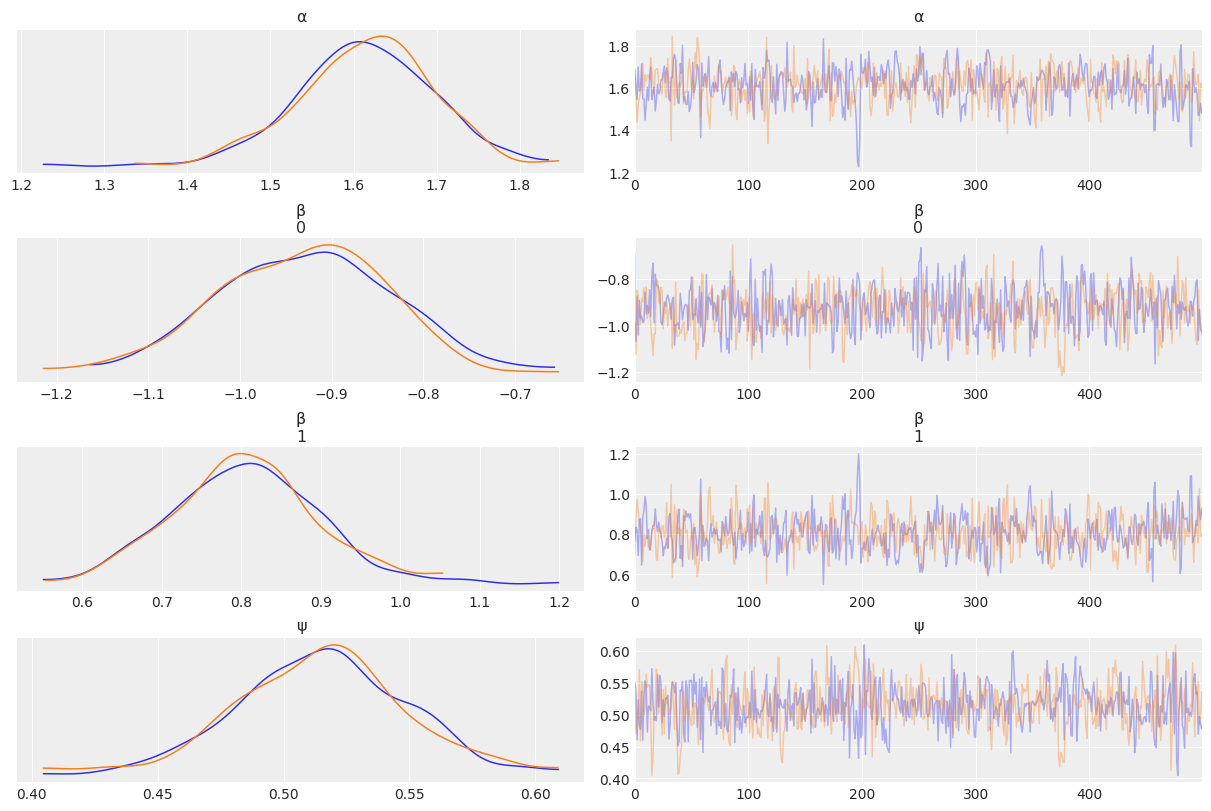

In [49]:
def model(obs=None):
    ψ = numpyro.sample('ψ', dist.Beta(concentration1=1, concentration0=1))
    α = numpyro.sample('α', dist.Normal(loc=0, scale=10))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=10), sample_shape=(2,))
    
    θ = jnp.exp(α + β[0] * jnp.asarray(fish_data['child']) + β[1] * jnp.asarray(fish_data['camper']))
    
    yl = numpyro.sample('yl', dist.ZeroInflatedPoisson(gate=ψ, rate=θ), obs=obs)
    
kernel = NUTS(model)
mcmc8 = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=2, chain_method='sequential')
mcmc8.run(random.PRNGKey(seed), obs=jnp.asarray(fish_data['count'])) 

az.plot_trace(mcmc8, compact=False, combined=False);

In [50]:
az.summary(mcmc8)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.613,0.083,1.462,1.769,0.003,0.002,622.0,771.0,1.0
β[0],-0.930,0.094,-1.106,-0.762,0.004,0.003,674.0,605.0,1.0
β[1],0.805,0.091,0.625,0.965,0.004,0.003,623.0,539.0,1.0
ψ,0.515,0.034,0.451,0.580,0.001,0.001,714.0,487.0,1.0


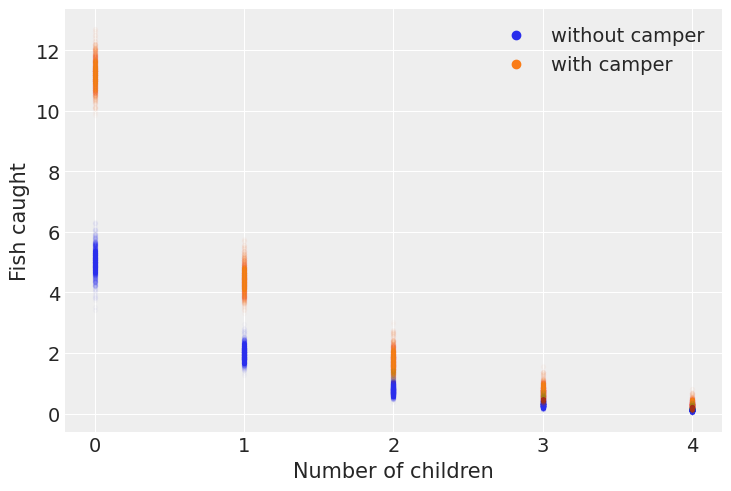

In [51]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
for n in children:
    without_camper = mcmc8.get_samples()['α'] + mcmc8.get_samples()['β'][:,0] * n
    with_camper = without_camper + mcmc8.get_samples()['β'][:,1]
    fish_count_pred_0.append(jnp.exp(without_camper))
    fish_count_pred_1.append(jnp.exp(with_camper))
    
    
plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend()

## Robust logistic regression

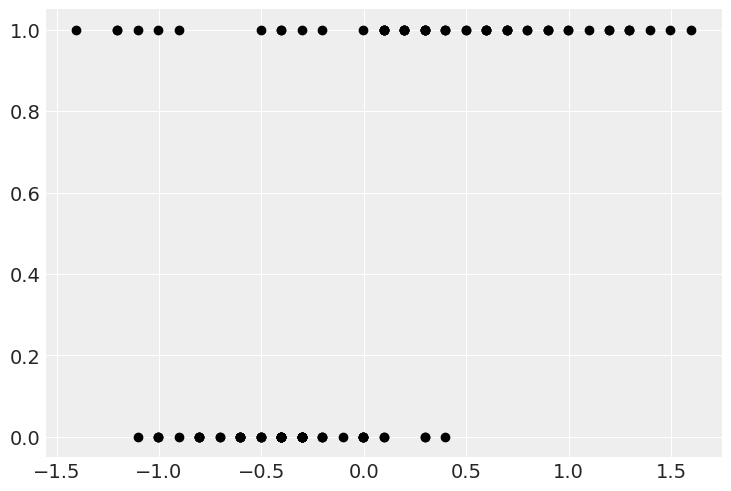

In [52]:
iris = sns.load_dataset("iris") 
df = iris.query("species == ('setosa', 'versicolor')") 
y_0 = pd.Categorical(df['species']).codes 
x_n = 'sepal_length'  
x_0 = df[x_n].values 
y_0 = jnp.concatenate((y_0, jnp.ones(6, dtype=int))) 
x_0 = jnp.concatenate((x_0, jnp.array([4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))) 
x_c = x_0 - x_0.mean() 
plt.plot(x_c, y_0, 'o', color='k');

In [53]:
def model(obs=None):
    
    α = numpyro.sample('α', dist.Normal(loc=0, scale=10))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=10))
    
    μ = α + x_c *  β  
    θ = numpyro.deterministic('θ', jnn.sigmoid(μ))
    bd = numpyro.deterministic('bd', -α/β)
    
    π = numpyro.sample('π', dist.Beta(concentration1=1., concentration0=1.))
    p = π * 0.5 + (1 - π) * θ 
    
    yl = numpyro.sample('yl', dist.Bernoulli(probs=p), obs=obs)

kernel = NUTS(model)
mcmc9 = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=2, chain_method='sequential')
mcmc9.run(random.PRNGKey(seed), obs=y_0) 

sample: 100%|██████████████████████████| 1000/1000 [00:00<00:00, 2268.58it/s, 7 steps of size 5.08e-01. acc. prob=0.90]


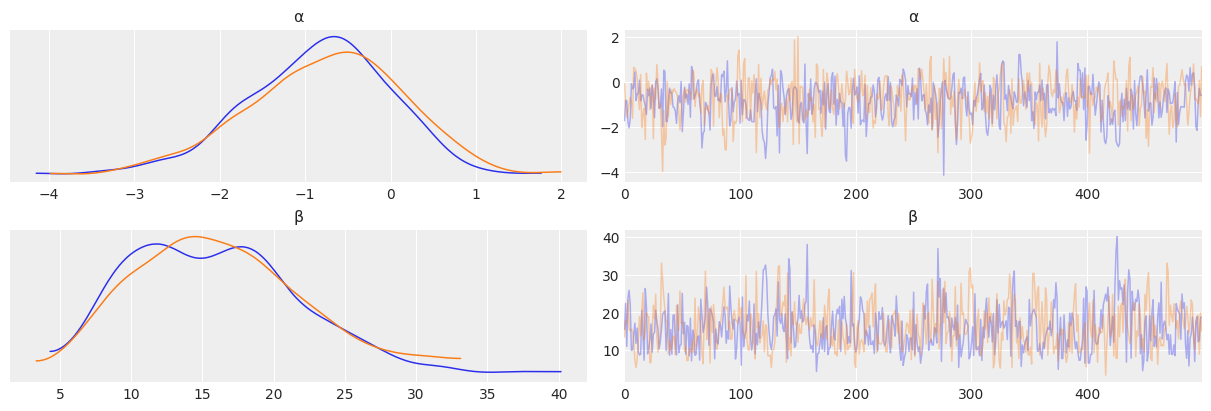

In [54]:
az.plot_trace(mcmc9, varnames, compact=False, combined=False);

In [55]:
varnames = ['α', 'β', 'bd']
az.summary(mcmc9, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.803,0.877,-2.483,0.814,0.036,0.026,609.0,584.0,1.0
β,16.157,6.057,5.312,26.757,0.282,0.202,479.0,647.0,1.0
bd,0.047,0.053,-0.061,0.143,0.002,0.001,755.0,632.0,1.0


([<matplotlib.axis.XTick at 0x13680e4f0>,
 [Text(-2.0, 0, '3.4'),
  Text(-1.5, 0, '3.9'),
  Text(-1.0, 0, '4.4'),
  Text(-0.5, 0, '4.9'),
  Text(0.0, 0, '5.4'),
  Text(0.5, 0, '5.9'),
  Text(1.0, 0, '6.4'),
  Text(1.5, 0, '6.9'),
  Text(2.0, 0, '7.4')])

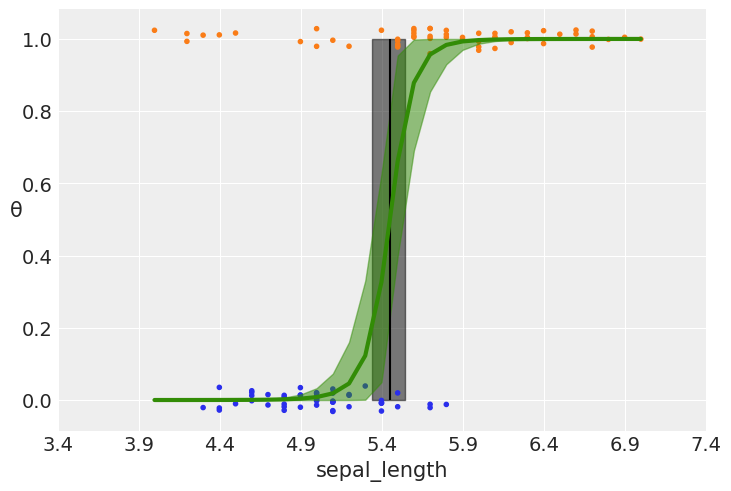

In [56]:
theta = mcmc9.get_samples()['θ'].mean(axis=0)
idx = jnp.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3);
plt.vlines(mcmc9.get_samples()['bd'].mean(), 0, 1, color='k')
bd_hdi = az.hdi(mcmc9.get_samples()['bd'].copy())

plt.fill_betweenx([0, 1], bd_hdi[0], bd_hdi[1], color='k', alpha=0.5)

plt.scatter(x_c, dist.Normal(y_0, 0.02).sample(random.PRNGKey(1)), marker='.', color=[f'C{x}' for x in y_0])
theta_hdi = az.hdi(mcmc9.get_samples()['θ'].copy())[idx]
plt.fill_between(x_c[idx], theta_hdi[:,0], theta_hdi[:,1], color='C2', alpha=0.5)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks() 
plt.xticks(locs, jnp.round(locs + x_0.mean(), 1))